### 產生特徵向量函式庫

In [1]:
import numpy as np
import cv2
import math
from scipy import ndimage
from matplotlib import pyplot as plt
import pandas as pd


isPlot=False
idDebug=False
STEP=1 #每次多少角度
granularity=int(180/STEP)

def imgWrapA(orgImg,a):
    img_a = ndimage.rotate(orgImg, a, reshape=False)    
    return img_a
        
def test_gen(a, x,y,wh):
    bigMap="img/map_2d.png"
    orgImg = cv2.cvtColor(cv2.imread(bigMap), cv2.COLOR_BGR2RGB)
    #print('orgImg shape=',orgImg.shape)

    #Question

    orgImg_crop128=orgImg[y-wh: y + wh, x-wh: x + wh ]
    if isPlot: plt.imshow(orgImg_crop128)
    orgImg_crop128_a33=imgWrapA(orgImg_crop128,a)
    #print('imgWrapA shape=',orgImg_crop128_a33.shape)
    orgImg_crop128_a33_crop=orgImg_crop128_a33[int(wh/4): int(3*wh/4), int(wh/4): int(3*wh/4)]

    return orgImg_crop128_a33_crop



def sizeStatistic(img, type=0):
    bigger=img>127
    #print(bigger)
    #print(bigger.shape)
    bigger_tmp=bigger[0:26,6:26]
    #bigger_tmp_2=bigger[0:26,7:27]
    sizeStatistic_result=np.zeros(8)
    for i in range(6):
        if type==0:
            bigger_tmp=np.logical_and(bigger_tmp ,bigger[i:26+i,6:26])
        elif type==1:
            bigger_tmp=np.logical_and(bigger_tmp ,bigger[0:26,6+i:26+i])
        elif type==2:
            bigger_tmp  =np.logical_and(bigger_tmp   ,bigger[0+i:26+i,6+i:26+i])
            #bigger_tmp_2=np.logical_and(bigger_tmp_2 ,bigger[0+i:26+i,7+i:27+i])
        elif type==3:
            bigger_tmp  =  np.logical_and(bigger_tmp   ,bigger[0+i:26+i,6-i:26-i])
            #bigger_tmp_2=np.logical_and(bigger_tmp_2 ,bigger[0+i:26+i,7-i:27-i])

        sizeStatistic_result[i]=sum(sum(bigger_tmp))
        #if type in [2,3]:  sizeStatistic_result[i] += sum(sum(bigger_tmp_2))
        if sizeStatistic_result[i]==0: break
    return sizeStatistic_result

def getFeature(sizeStatisticResult):
    s_result_diff=np.abs(np.diff(sizeStatisticResult[0:7]))
    s_result_diff_norm=s_result_diff/sum(s_result_diff)
    s_result_all=s_result_diff_norm#計算差值 加上normilize
    s_result_all=s_result_all+1 #避免出現 1, 準備log
    s_result_all=np.log(s_result_all)#log
    s_result_all=np.around(s_result_all, decimals=4)
    return s_result_all

#由圖檔得特徵向量，未知旋轉角度，應用時候可採用   
def getFeatures(monoImg):
    Features=np.zeros(24)
    for i in range(4):
        sizeStatisticResult=sizeStatistic(monoImg, i) 
        #print(i,sizeStatisticResult)
        Features[i*6:6+i*6]=getFeature(sizeStatisticResult)
    return Features

def getYandFeatures(a, monoImg):
    s_result_all=np.zeros(1+24)
    s_result_all[0]=a
    s_result_all[1:25]=getFeatures(monoImg)
    return s_result_all

#給定座標及轉角 可以得到一個特徵向量    
def genFeatureVector(a,x,y):
    challenge=test_gen(a,x,y,64);
    s_result_all=getYandFeatures(a, challenge[:,:,2])

    return s_result_all



### 特徵向量觀察工具

In [2]:


def plot4view(s_result_all):
    plt.subplots(1,4,figsize=(10,3))    
    for i in range(4):
        plt.subplot(141+i)
        plt.plot(s_result_all[1+1+i*6,0:granularity], label = "l2")# 1 表示為 角度（答案）
        plt.plot(s_result_all[1+2+i*6,0:granularity], label = "l3")
        plt.plot(s_result_all[1+3+i*6,0:granularity], label = "l4")
        plt.plot(s_result_all[1+4+i*6,0:granularity], label = "l5")
        plt.plot(s_result_all[1+5+i*6,0:granularity], label = "l6")
        plt.legend()
    plt.show()



### 生成數據集合函數

In [3]:
def mass_sample(times, xlist, ylist):
    s_result_all=np.zeros([1+24,times*granularity+1])# 1 表示為 角度（答案）
    for i in range(times):
        for a in range(0,granularity+1,STEP):
            s_result_all[:,a+i*granularity]=genFeatureVector(a,xlist[i],ylist[i]) 
    return s_result_all

### 驗證

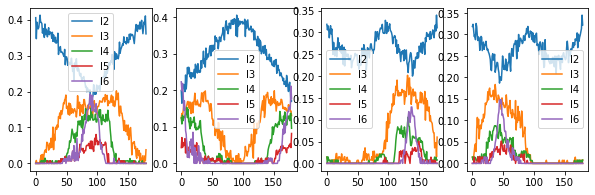

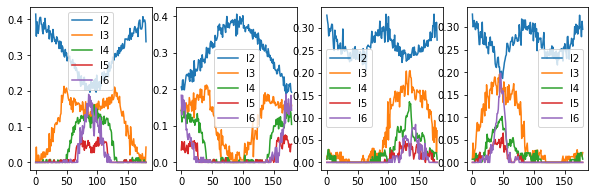

In [4]:
#test one
xlist=[210,200]
ylist=[150,133]
s_result_all=mass_sample(2, xlist, ylist)
plot4view(s_result_all[:,0:granularity])
plot4view(s_result_all[:,granularity:2*granularity])
# convert array into dataframe
DF = pd.DataFrame(np.transpose(s_result_all))
 
# save the dataframe as a csv file
DF.to_csv("s_result_all.csv")

### 生成數據集合

In [5]:
def mass_sample(times, xlist, ylist):
    s_result_all=np.zeros([1+24,times*granularity+1])# 1 表示為 角度（答案）
    for i in range(times):
        for a in range(0,granularity+1,STEP):
            s_result_all[:,a+i*granularity]=genFeatureVector(a,xlist[i],ylist[i]) 
    return s_result_all



#測試用數據集合
tryNumber=100
xlist=np.around(np.random.rand(tryNumber)*300+100).astype(int)
ylist=np.around(np.random.rand(tryNumber)*300+100).astype(int)
s_result_all=mass_sample(tryNumber, xlist, ylist)
DF = pd.DataFrame(np.transpose(s_result_all))
DF.to_csv("s_result_all_100.csv")

#訓練用數據集合
tryNumber=1000
xlist=np.around(np.random.rand(tryNumber)*300+100).astype(int)
ylist=np.around(np.random.rand(tryNumber)*300+100).astype(int)
s_result_all=mass_sample(tryNumber, xlist, ylist)
DF = pd.DataFrame(np.transpose(s_result_all))
DF.to_csv("s_result_all_1000.csv")
